# Getting the Environment Ready

## Installation
Before we can begin working with the AI chess player code, we need to set up the required environment and install necessary dependencies. Here's how you can get started:


> Note that the ! at the beginning indicates running a shell command within the notebook (assuming you are using Jupyter or Google Colab).



In [ ]:
# Install required Python packages
%pip install python-chess
%pip install stockfish
%pip install svglib
%pip install cairosvg
%pip install pdf2image
# Install poppler-utils for PDF handling
!apt-get install poppler-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.0 MB/s eta 0:00:00
  Created wheel for svglib: filename=svglib-1.5.1-py3-none-any.whl size=30902 sha256=b5305ceb41222b9c537384f66eb47c3c8fdaf318e38065bbeb667484e3f7123f
  Stored in directory: /root/.cache/pip/wheels/56/9f/90/f37f4b9dbf82987a24ae14f15586e96715cb669a4710b3b85d
Successfully built svglib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 3.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 186 kB of archives.
After this operation

## importing Packages
To ensure the AI chess player code functions properly, the following packages are imported. These packages enable various functionalities, including data manipulation, visualization, machine learning, and interfacing with chess engines.

In [ ]:
import re
import os
import chess
import pickle
import imageio
import datetime
import cairosvg
import subprocess
import chess.engine

import numpy as np
import pandas as pd
import seaborn as sns
import chess.pgn as pgn
import matplotlib.pyplot as plt

from time import sleep
from sklearn import metrics
from stockfish import Stockfish
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from pdf2image import convert_from_path
from IPython.display import display, HTML, clear_output

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

from sklearn.model_selection import train_test_split

## Define
Define various constants and settings for the code


In [ ]:
LOADING_DATA = True
TRAINGING_MODELS = True
RETRAINING_MODELS = True
USE_CACHE = True
BOARD_SIZE = (8, 8, 6)
PIECE_TO_INDEX = {'P': 0, 'R': 1, 'N': 2, 'B': 3, 'Q': 4, 'K': 5}
CHESSY_TO_Y = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}
INDEX_TO_PIECE = {0: 'P', 1: 'R', 2: 'N', 3: 'B', 4: 'Q', 5: 'K'}
Y_TO_CHESSY = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h'}
ARRAY_PIECE = ['P','R','Q','K','B','N']
BOOLEAN_PIECE = {'P': False, 'R': False, 'Q': False,
                 'K': False, 'B': False,'N': False}
PIECE_TO_WORD = {'P': 'Pawn', 'Q': 'Queen', 'K': 'King',
                 'N': 'Knight', 'R': 'Rook', 'B': 'Bishop'}

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Give execute permissions to Stockfish engine
!chmod 777 "/content/drive/MyDrive/Chess_data/models/stockfish-ubuntu-x86-64-avx2"

In [ ]:
# Define paths for various directories and files
PGN_FILE_PATH = "/content/drive/MyDrive/Chess_data/pgn_files/"
GIF_FILE_PATH = "/content/drive/MyDrive/Chess_data/games_gif/"
MODELS_PATH = "/content/drive/MyDrive/Chess_data/models/"
TEMP_PATH = "/content/output_images/"
DATASET_PATH = '/content/drive/MyDrive/Chess_data/'
STOCKFISH_PATH = "/content/drive/MyDrive/Chess_data/models/stockfish-ubuntu-x86-64-avx2"
PGN_FILE = '/content/drive/MyDrive/Chess_data/FICS_2000.pgn'
DATASET_PUZZLES_PATH = '/content/drive/MyDrive/Chess_data/puzzles/'

In [ ]:
# Initialize the chess engine
engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)

In [ ]:
# Create the temporary directory if it doesn't exist
if not os.path.exists(TEMP_PATH):
    os.makedirs(TEMP_PATH)

# Helper Functions


## Basic Functions

In [ ]:
# Initialize the chess board with the initial piece setup
def initialize_board():
    """
    Initializes the chess board with the initial piece setup.
    Returns a 3D numpy array representing the initial piece setup.
    """
    board = np.zeros(BOARD_SIZE)
    pattern = ['R', 'N', 'B', 'Q', 'K', 'B', 'N', 'R']

    # Putting the black non-pawn pieces
    for index, piece in enumerate(pattern):
        board[0, index, PIECE_TO_INDEX[piece]] = -1

    # Putting the black pawns
    board[1, :, PIECE_TO_INDEX['P']] = -1

    # Putting the white non-pawn pieces
    for index, piece in enumerate(pattern):
        board[BOARD_SIZE[0] - 1, index, PIECE_TO_INDEX[piece]] = 1

    # Putting the white pawns
    board[BOARD_SIZE[0] - 2, :, PIECE_TO_INDEX['P']] = 1

    return board

In [ ]:
# Convert a bitboard representation to an image representation
def convert_bitboard_to_image(board):
    """
    Converts a chess board to its corresponding bitboard image.
    Returns a 3D numpy array representing the bitboard image.
    """
    im2d = np.array(list(str(board).replace('\n', '').replace(' ', ''))).reshape((8, 8))
    im = np.zeros(BOARD_SIZE)

    for i in range(BOARD_SIZE[0]):
        for j in range(BOARD_SIZE[1]):
            piece = im2d[i, j]
            if piece == '.': continue
            if piece.isupper():
                im[i, j, PIECE_TO_INDEX[piece.upper()]] = 1
            else:
                im[i, j, PIECE_TO_INDEX[piece.upper()]] = -1

    return im

# Convert an image representation back to a bitboard representation
def convert_image_to_bitboard(im):
    """
    Converts an image representation back to a bitboard representation.
    Returns the corresponding chess.Board object.
    """
    board = chess.Board()
    board.clear()
    for i in range(BOARD_SIZE[0]):
        for j in range(BOARD_SIZE[1]):
            index_piece = np.where(im[(i, j)] != 0)
            index_piece = index_piece[0]
            new_coords = flatten_coord2d((7 - i, j))
            if index_piece.shape != (0,):
                piece = INDEX_TO_PIECE[index_piece[0]]
                if im[(i, j, index_piece[0])] == -1:
                    piece = piece.lower()
                board.set_piece_at(new_coords, chess.Piece.from_symbol(piece))

    return board

In [ ]:
# Convert a 2D coordinate to a flattened index for bitboards
def flatten_coord2d(coord2d):
    """
    Converts a 2D coordinate to a flattened index for bitboards.
    Returns the flattened index.
    """
    return (8 * coord2d[0]) + coord2d[1]

In [ ]:
# Flip the rows of an image (for switching between black and white perspectives)
def flip_image(im):
    """
    Flips an image horizontally.
    Returns the horizontally flipped image.
    """
    return im[::-1, :, :]

# Flip the colors of an image (invert piece colors)
def flip_color(im):
    """
    Flips the colors of an image (invert white and black).
    Returns the image with inverted colors.
    """
    indices_white = np.where(im == 1)
    indices_black = np.where(im == -1)
    im[indices_white] = -1
    im[indices_black] = 1
    return im

# Convert a 2D coordinate to its flipped counterpart
def flip_coord2d(coord2d):
    """
    Converts a 2D coordinate to its flipped counterpart.
    Returns the flipped 2D coordinate.
    """
    return 8 - coord2d[0] - 1, coord2d[1]

In [ ]:
# Convert a 2D coordinate to chess notation coordinate
def coord2d_to_chess_coord(coord2d):
    """
    Converts a 2D coordinate to chess notation coordinate.
    Returns the chess notation coordinate as a string.
    """
    chess_coord = Y_TO_CHESSY[coord2d[1]] + str(8 - coord2d[0])
    return chess_coord

# Convert a chess notation coordinate to a 2D coordinate
def chess_coord_to_coord2d(chess_coord):
    """
    Converts a chess notation coordinate to a 2D coordinate.
    Returns the 2D coordinate as a tuple (row, column).
    """
    return 8 - int(chess_coord[1]), CHESSY_TO_Y[chess_coord[0]]

In [ ]:
# Clip piece probabilities to zeros based on board state
def clip_pieces(prob_dists, ims):
    """
    Clips piece probabilities to zeros based on board state.
    Returns the filtered probability distributions.
    """
    mask = ims > 0
    rotated_mask = np.rollaxis(mask, 3, 1)  # Convert to form (num_samples, C, H, W)

    or_channels = np.any(rotated_mask, axis=1)
    filter = or_channels.reshape(or_channels.shape[0], 64)

    prob_dists_filtered = prob_dists * filter
    return prob_dists_filtered

# Clip move probabilities to zeros based on legal moves
def clip_move(prob_dist, im, coord, piece_type=None, castle_rights={'Q':False,'K':False}):
    """
    Clips move probabilities to zeros based on legal moves.
    Returns the filtered move probabilities.
    """
    board = convert_image_to_bitboard(im)

    if castle_rights['K']:
      board.castling_rights |= chess.BB_A1

    if castle_rights['Q']:
      board.castling_rights |= chess.BB_H1

    piece_coord = coord2d_to_chess_coord(coord)
    for i in range(BOARD_SIZE[0]):
        for j in range(BOARD_SIZE[1]):
            to_coord = coord2d_to_chess_coord((i, j))
            if piece_coord == to_coord:
                prob_dist[i * 8 + j] = 0
                continue
            uci_move = piece_coord + to_coord

            if piece_type == 'P':
                if uci_move[3:] == '8':
                    uci_move += 'q'

            if chess.Move.from_uci(uci_move) not in board.legal_moves:
                prob_dist[i * 8 + j] = 0

    return prob_dist

## Loading Functions


In [ ]:
# Get the winner of the game ('White', 'Black', or 'Draw')
def get_winner(game):
    """
    Gets the winner of a chess game from the game headers.
    Returns 'White', 'Black', or 'Draw'.
    """
    result = game.headers.get('Result')
    if result == '1-0':
        return 'White'
    elif result == '0-1':
        return 'Black'
    else:
        return 'Draw'

# Get the rating of a player based on color
def get_player_rating(game, color):
    """
    Gets the rating of a player in a chess game from the game headers.
    Returns the player's rating as an integer or None if not available.
    """
    player_rating = None
    if 'WhiteElo' in game.headers and color == 'White':
        player_rating = int(game.headers['WhiteElo'].split(' ')[-1])
    elif 'BlackElo' in game.headers and color == 'Black':
        player_rating = int(game.headers['BlackElo'].split(' ')[-1])

    return player_rating

In [ ]:
# Load PGN games from a file with filtering based on player ratings
def load_pgn_games(file_name, num_games, flag):
    """
    Loads PGN chess games from a file and filters them based on ratings.
    Returns a list of tuples containing game objects and the winners.
    """
    games = []
    pgn_file = open(file_name)
    counter = 0
    while  counter < num_games * 2:
        if flag and counter == num_games:
            break
        game = chess.pgn.read_game(pgn_file)
        if game is None:
            break

        white_rating = get_player_rating(game, 'White')
        black_rating = get_player_rating(game, 'Black')

        if white_rating is not None and black_rating is not None and white_rating > 2000 and black_rating > 2000:
            winner = get_winner(game)
            counter += 1
            if flag:
                games.append((game, winner))
            elif counter > num_games:
                games.append((game, winner))

    pgn_file.close()
    return games

In [ ]:
# Check the phase of the game based on move index and piece counts
def check_phase(board, move_index):
    """
    Checks the phase of the game based on move index and piece counts.
    Returns 'o' for opening, 'e' for endgame, or 'm' for middle game.
    """
    if move_index <= 20:
        return 'o'
    count = 0
    count_pawn = 0
    for piece_type in [chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.PAWN]:
        for color in [chess.WHITE, chess.BLACK]:
            squares = board.pieces(piece_type, color)
            count += len(squares)
            count_pawn += len(squares) if piece_type == chess.PAWN else 0
    if count <= 7:
        return 'e'
    if count - count_pawn <= 5:
        return 'e'
    if count_pawn <= 5:
        return 'e'
    return 'm'

In [ ]:
# Save data using pickle
def save_data(data, filename):
   with open(DATASET_PATH + filename + '.pkl', 'wb') as f:
      pickle.dump(data, f, protocol=4)

In [ ]:
# Function to retrieve data from saved pickle files
def get_data(filename):

    # Load the X_train data from the corresponding pickle file
    with open(DATASET_PATH + 'X' + filename + '.pkl', 'rb') as f:
        X = pickle.load(f)


    # Load the y_train data from the corresponding pickle file
    with open(DATASET_PATH + 'y' + filename + '.pkl', 'rb') as f:
        y = pickle.load(f)

    return X, y

In [ ]:
# Function to retrieve data from saved pickle files
def get_puzzles_data(filename):

    # Load the X_train data from the corresponding pickle file
    with open(DATASET_PUZZLES_PATH + 'X_puzzle' + filename + '.pkl', 'rb') as f:
        X = pickle.load(f)


    # Load the y_train data from the corresponding pickle file
    with open(DATASET_PUZZLES_PATH + 'y_puzzle' + filename + '.pkl', 'rb') as f:
        y = pickle.load(f)

    return X, y

In [ ]:
# Function to load a trained piece model
def load_my_model(piece_label):

    # Define the path to the saved model file
    PATH = MODELS_PATH + "chess_model_CNN_" + piece_label + ".h5"

    # Load the saved model using Keras' load_model function
    loaded_model = load_model(PATH)

    # Return the loaded model
    return loaded_model

## Model Structure

In [ ]:
# Create the piece recognition neural network
def create_piece_net():
    """
    Creates a neural network model for predicting piece moves.
    Returns the compiled Keras model.
    """
    scale = 10**(-7)
    stddev = scale / 2.0
    scale2 = 10**(-6)
    stddev2 = scale2 / 2.0

    model = keras.Sequential()
    model.add(Conv2D(96, kernel_size=3, padding='same', activation='relu',
                     kernel_initializer=RandomNormal(mean=0.0, stddev=stddev),
                     input_shape=(8, 8, 6)))

    model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu',
                     kernel_initializer=RandomNormal(mean=0.0, stddev=stddev)))

    model.add(Conv2D(384, kernel_size=3, padding='same', activation='relu',
                     kernel_initializer=RandomNormal(mean=0.0, stddev=stddev)))

    model.add(Flatten())

    model.add(Dense(64, activation='softmax',
                    kernel_initializer=RandomNormal(mean=0.0, stddev=stddev2)))
    return model

In [ ]:
# Create the move prediction neural network
def create_move_net():
    """
    Creates a neural network model for predicting move outcomes.
    Returns the compiled Keras model.
    """
    scale = 10**(-7)
    stddev = scale / 2.0
    scale2 = 10**(-6)
    stddev2 = scale2 / 2.0

    model = keras.Sequential()
    model.add(Conv2D(96, kernel_size=3, padding='same', activation='relu',
                     kernel_initializer=RandomNormal(mean=0.0, stddev=stddev),
                     input_shape=(8, 8, 6)))

    model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu',
                     kernel_initializer=RandomNormal(mean=0.0, stddev=stddev)))

    model.add(Conv2D(384, kernel_size=3, padding='same', activation='relu',
                     kernel_initializer=RandomNormal(mean=0.0, stddev=stddev)))

    model.add(Flatten())

    model.add(Dense(64, activation='softmax',
                    kernel_initializer=RandomNormal(mean=0.0, stddev=stddev2)))
    return model

## Prediction Functions

### Prediction From Functions

In [ ]:
# Predict the best k possible cells that can have our pieces from a given board position
def predict_from_k_move(board, k):
    """
    Predicts the best k moves from the current board position using the trained model.
    Returns a list of k best moves.
    """
    # Convert the board to image format
    if board.turn:
      im = convert_bitboard_to_image(board)
    else:
      im = flip_image(convert_bitboard_to_image(board))
      im = flip_color(im)

    img = im.reshape(1, 8, 8, 6)

    # Predict the best piece to move from the base model
    from_move = model_cpu['base_model'].predict(img, verbose = 0)
    from_move = clip_pieces(from_move, img)

    best_moves = []

    # Generate a list of best k pieces with their probabilities
    for index, prob in enumerate(from_move[0]):
      from_cell_index = index
      from_cell_coord = [index // 8, index % 8]
      if not board.turn:
        from_cell_coord[0] = 7 - from_cell_coord[0]
      best_moves.append([prob, coord2d_to_chess_coord(from_cell_coord)])

    # Sort the list based on probabilities and select k best cells
    sorted_best_moves = sorted(best_moves, key=lambda x: x[0], reverse=True)
    best_k_moves_with_prob = sorted_best_moves[:k]
    best_k_moves = [element[1] for element in best_k_moves_with_prob]

    return best_k_moves

In [ ]:
# Predict the best k possible cells that has our pieces from multiple FEN positions
def predict_multi_from_k_move(fens, k):
    """
    Predicts the best k moves for multiple board positions using the trained model.
    Returns a list of k best moves for each board position.
    """
    boards = []
    for fen in fens:
      boards.append(chess.Board(fen=fen))

    # Determine the device for computation (GPU or CPU)
    if len(tf.config.list_physical_devices('GPU')) > 0:
        device = '/gpu:0'
    else:
        device = '/cpu:0'

    images = []
    for board in boards:
      if board.turn:
        im = convert_bitboard_to_image(board)
      else:
        im = flip_image(convert_bitboard_to_image(board))
        im = flip_color(im)

      img = im.reshape(1, 8, 8, 6)
      images.append(img)

    images_np = np.array(np.vstack(images)).astype(int)

    # Predict the best pieces to move from the base model for all board positions
    with tf.device(device):
        images_tensor = tf.convert_to_tensor(images_np)

    from_moves = model['base_model'].predict(images_tensor, verbose = 0)
    moves = []

    # Generate a list of k best pieces for each board position
    for i, from_move in enumerate(from_moves):
      from_move2 = clip_pieces(from_move, images[i])
      best_moves = []
      for index, prob in enumerate(from_move2[0]):
        if prob > 0:
          from_cell_coord = [index // 8, index % 8]
          from_move_index = chess.square_mirror(index) if board.turn else index
          move_from = chess.square_name(from_move_index)
          best_moves.append([prob, move_from])

      # Sort the list based on probabilities and select k best cells
      sorted_best_moves = sorted(best_moves, key=lambda x: x[0], reverse=True)
      best_k_moves_with_prob = sorted_best_moves[:k]
      best_k_moves = [element[1] for element in best_k_moves_with_prob]

      moves.append(best_k_moves)

    return moves

### Prediction Full Move Functions

In [ ]:
def predict_k_move_special(board, k, k_from):
    if board.turn:
      im = convert_bitboard_to_image(board)
    else:
      im = flip_image(convert_bitboard_to_image(board))
      im = flip_color(im)

    img = im.reshape(1, 8, 8, 6)
    from_move = model_cpu['base_model'].predict(img, verbose = 0)
    from_move = clip_pieces(from_move, img)
    from_move_short = [[i, from_m] for i, from_m in enumerate(from_move[0])]
    from_move_short = sorted(from_move_short, key=lambda x: x[1], reverse=True)
    from_move_short = from_move_short[:k_from]

    best_moves = []
    for index, prob in from_move_short:
      if prob > 0:
        from_cell_coord = [index // 8, index % 8]
        pieceType = INDEX_TO_PIECE[np.argmax(img[:, from_cell_coord[0], from_cell_coord[1]])]
        to_move = model_cpu['move_models'][pieceType].predict(img, verbose = 0)

        castling_rights = {'K':board.has_kingside_castling_rights(color=chess.WHITE),
                            'Q':board.has_queenside_castling_rights(color=chess.WHITE)}

        to_move = clip_move(to_move[0], im, from_cell_coord,
                            pieceType, castling_rights)

        for index2, prob2 in enumerate(to_move):
          if prob2 > 0:
            from_move_index = chess.square_mirror(index) if board.turn else index
            to_move_index = chess.square_mirror(index2) if board.turn else index2
            move_from_to = chess.square_name(from_move_index) + chess.square_name(to_move_index)

            if pieceType == 'P':
              if board.turn:
                if move_from_to[3:] == '8':
                  move_from_to += 'q'
              else:
                if move_from_to[3:] == '1':
                  move_from_to += 'q'
            best_moves.append([prob * prob2, move_from_to])

    sorted_best_moves = sorted(best_moves, key=lambda x: x[0], reverse=True)

    best_k_moves_with_prob = sorted_best_moves[:k]

    best_k_moves = [element[1] for element in best_k_moves_with_prob]

    return best_k_moves

In [ ]:
# Predict the best k full moves from a given board position
def predict_k_move(board, k):
    """
    Predicts the best k full moves from a given board position using the trained model.
    Returns a list of k best full moves.
    """
    # Convert the board to image format
    if board.turn:
      im = convert_bitboard_to_image(board)
    else:
      im = flip_image(convert_bitboard_to_image(board))
      im = flip_color(im)

    img = im.reshape(1, 8, 8, 6)
    from_move = model_cpu['base_model'].predict(img, verbose = 0)
    from_move = clip_pieces(from_move, img)
    best_moves = []

    # Predict the 'to' move for each 'from' move candidate
    for index, prob in enumerate(from_move[0]):
      if prob > 0:
        from_cell_coord = [index // 8, index % 8]
        pieceType = INDEX_TO_PIECE[np.argmax(img[:, from_cell_coord[0], from_cell_coord[1]])]
        to_move = model_cpu['move_models'][pieceType].predict(img, verbose = 0)

        # Adding the castling rights to the board
        castling_rights = {'K':board.has_kingside_castling_rights(color=chess.WHITE),
                            'Q':board.has_queenside_castling_rights(color=chess.WHITE)}

        to_move = clip_move(to_move[0], im, from_cell_coord,
                            pieceType, castling_rights)

        for index2, prob2 in enumerate(to_move):
          if prob2 > 0:
            from_move_index = chess.square_mirror(index) if board.turn else index
            to_move_index = chess.square_mirror(index2) if board.turn else index2
            move_from_to = chess.square_name(from_move_index) + chess.square_name(to_move_index)

            # Adding promotion to the pawn movement if it reachs the last rank
            if pieceType == 'P':
              if board.turn:
                if move_from_to[3:] == '8':
                  move_from_to += 'q'
              else:
                if move_from_to[3:] == '1':
                  move_from_to += 'q'
            best_moves.append([prob * prob2, move_from_to])

    # Sort the list based on probabilities and select k best moves
    sorted_best_moves = sorted(best_moves, key=lambda x: x[0], reverse=True)
    best_k_moves_with_prob = sorted_best_moves[:k]
    best_k_moves = [element[1] for element in best_k_moves_with_prob]

    return best_k_moves

In [ ]:
# Predict the best k full moves from multiple FEN positions
def predict_multi_k_move(fens, k):
    """
    Predicts the best k full moves for multiple FEN positions using the trained model.
    Returns a list of k best full moves for each FEN position.
    """
    boards = []
    for fen in fens:
      boards.append(chess.Board(fen=fen))

    # Determine the device for computation (GPU or CPU)
    if len(tf.config.list_physical_devices('GPU')) > 0:
        device = '/gpu:0'
    else:
        device = '/cpu:0'

    images = []
    for board in boards:
      if board.turn:
        im = convert_bitboard_to_image(board)
      else:
        im = flip_image(convert_bitboard_to_image(board))
        im = flip_color(im)

      img = im.reshape(1, 8, 8, 6)
      images.append(img)

    images_np = np.array(np.vstack(images)).astype(int)

    # Perform prediction for 'from' moves on the specified device
    with tf.device(device):
        images_tensor = tf.convert_to_tensor(images_np)

    from_moves = model['base_model'].predict(images_tensor, verbose = 0)
    moves = []
    pieceTypes = []
    image_piece = {}

    # Collect piece types and their corresponding images
    for i, from_move in enumerate(from_moves):
      from_move2 = clip_pieces(from_move, images[i])
      for index, prob in enumerate(from_move2[0]):
        if prob > 0:
          from_cell_coord = [index // 8, index % 8]
          pieceType = INDEX_TO_PIECE[np.argmax(images[i][:, from_cell_coord[0], from_cell_coord[1]])]
          pieceTypes.append(pieceType)
          if not pieceType in image_piece:
            image_piece[pieceType] = []
          image_piece[pieceType].append(images[i])

    to_moves = {}
    # Predict 'to' moves for each piece type using their corresponding images
    for key, images_value in image_piece.items():
      images_value = np.array(np.vstack(images_value)).astype(int)
      with tf.device(device):
        images_tensor_value = tf.convert_to_tensor(images_value)
      to_moves[key] = []
      res = model['move_models'][key].predict(images_tensor_value, verbose = 0)
      to_moves[key] = res.tolist()

    # Calculate the propablity distribution over all the moves
    for i, from_move in enumerate(from_moves):
      best_moves = []
      from_move2 = clip_pieces(from_move, images[i])
      for index, prob in enumerate(from_move2[0]):
        if prob > 0:
          from_cell_coord = [index // 8, index % 8]
          pieceType = pieceTypes.pop(0)
          to_move = to_moves[pieceType].pop(0)

          # Adding the castling rights to the board
          castling_rights = {'K':boards[i].has_kingside_castling_rights(color=chess.WHITE),
                             'Q':boards[i].has_queenside_castling_rights(color=chess.WHITE)}

          to_move = clip_move(to_move, images[i][0], from_cell_coord,
                              pieceType, castling_rights)

          for index2, prob2 in enumerate(to_move):
            if prob2 > 0:
              from_move_index = chess.square_mirror(index) if board.turn else index
              to_move_index = chess.square_mirror(index2) if board.turn else index2
              move_from_to = chess.square_name(from_move_index) + chess.square_name(to_move_index)

              # Adding promotion to the pawn movement if it reachs the last rank
              if pieceType == 'P':
                if board.turn:
                  if move_from_to[3:] == '8':
                    move_from_to += 'q'
                else:
                  if move_from_to[3:] == '1':
                    move_from_to += 'q'
              best_moves.append([prob * prob2, move_from_to])

      # Sort the list based on probabilities and select k best moves
      sorted_best_moves = sorted(best_moves, key=lambda x: x[0], reverse=True)
      best_k_moves_with_prob = sorted_best_moves[:k]
      best_k_moves = [element[1] for element in best_k_moves_with_prob]

      moves.append(best_k_moves)

    return moves

### Cache Functions

In [ ]:
# Maximum number of cached entries
MAX_CACHE_SIZE = 1000

# Number of cached entries to evict when the cache is full
EVICTION_BATCH_SIZE = 100

# Initialize cache statistics
cache_called = 0
cache_hit = 0

# Cache to store k-move predictions
k_move_cache = {}

# Queue to track cache usage (used for eviction)
cache_usage_queue = []

# Predict the best k full moves from a given board position using cache
def predict_k_move_cached(board, k):
    """
    Predicts the best k full moves from a given board position using cache or model.
    Returns a list of k best full moves.
    """
    # If caching is disabled, fall back to regular prediction
    if not USE_CACHE:
      return predict_k_move(board, k)
    global cache_hit
    global cache_called
    global k_move_cache
    global cache_usage_queue
    fen_hash = hash(board.fen())
    cache_called += 1

    # If the FEN hash is in the cache, return the cached result
    if fen_hash in k_move_cache:
        cache_hit += 1
        cache_usage_queue.remove(fen_hash)
        cache_usage_queue.insert(0, fen_hash)
        return k_move_cache[fen_hash]

    # Predict k moves and update the cache
    k_moves = predict_k_move(board, k)

    # Evict entries from the cache if the cache is full
    if len(k_move_cache) >= MAX_CACHE_SIZE:
        evicted_hashes = cache_usage_queue[-EVICTION_BATCH_SIZE:]
        for evicted_hash in evicted_hashes:
            k_move_cache.pop(evicted_hash)
            cache_usage_queue.remove(evicted_hash)

    # Store the new entry in the cache and update the usage queue
    k_move_cache[fen_hash] = k_moves
    cache_usage_queue.insert(0, fen_hash)

    return k_moves

In [ ]:
def predict_k_move_cached_special(board, k, k_from):
    if not USE_CACHE:
      return predict_k_move_special(board, k, k_from)

    global cache_hit
    global cache_called
    global k_move_cache
    global cache_usage_queue

    fen_hash = hash(board.fen())
    cache_called += 1
    if fen_hash in k_move_cache:
        cache_hit += 1
        cache_usage_queue.remove(fen_hash)
        cache_usage_queue.insert(0, fen_hash)
        return k_move_cache[fen_hash]

    k_moves = predict_k_move_special(board, k, k_from)

    if len(k_move_cache) >= MAX_CACHE_SIZE:
        evicted_hashes = cache_usage_queue[-EVICTION_BATCH_SIZE:]
        for evicted_hash in evicted_hashes:
            k_move_cache.pop(evicted_hash)
            cache_usage_queue.remove(evicted_hash)

    k_move_cache[fen_hash] = k_moves
    cache_usage_queue.insert(0, fen_hash)

    return k_moves

In [ ]:
# Clear the cache
def clear_cache():
    """
    Clears the cache and resets cache statistics.
    """
    global cache_called
    global cache_hit
    global k_move_cache
    global cache_usage_queue
    cache_called = 0
    cache_hit = 0
    k_move_cache = {}
    cache_usage_queue = []

In [ ]:
# Clear cache statistics
def clear_cache_numbers():
    """
    Resets cache usage statistics.
    """
    global cache_called
    global cache_hit
    cache_called = 0
    cache_hit = 0

## Stockfish Functions

In [ ]:
# Calculate the Stockfish evaluation score for a given board position
def stockfish_evaluation(board, time_limit = 2):
    """
    Calculates the evaluation score and mate status of the current board position using Stockfish.
    Returns the evaluation score (in centipawns) and mate status (1 if checkmate, -1 if stalemate, 0 otherwise).
    """
    global engine
    info = engine.analyse(board, chess.engine.Limit(time=time_limit,depth=15),game=object())
    evaluation = info["score"].relative
    # If the evaluation is a mate score, extract the mate value and sign
    if evaluation.is_mate():
        mate_sign = str(info["score"].relative)[1:][:1]
        mate = int(str(info["score"].relative)[2:])
        return mate, (1 if mate_sign == '+' else -1)
    else:
        return int(evaluation.cp), 0

In [ ]:
# Let Stockfish play a move for a given board position
def stockfish_play(board, time_limit = 0.1):
    """
    Uses Stockfish to suggest the best move for the current board position within the specified time limit.
    Returns the move recommended by Stockfish.
    """
    global engine
    result = engine.play(board, chess.engine.Limit(time=time_limit))
    return result.move

In [ ]:
def count_pieces(board):
    piece_counts = {
        chess.WHITE: 0,
        chess.BLACK: 0
    }

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            piece_counts[piece.color] += 1

    return piece_counts

In [ ]:
DEPTH = 3
K_BEST = 3
K_FROM = 6
EVAL_TIME_LIMIT = 0.1
NOM_D_K = {0:(1,1), 5: (2,2), 10:(3,3)}
NOM_ARR = [10, 5, 0]

def decide(board, k_from, eval_time_limit, basic=False):
    if count_pieces(board)[board.turn] < 7:
        best_move = find_best_move_special(board, 4, 4, k_from, eval_time_limit)
    else :
        for nom in NOM_ARR:
            if(board.fullmove_number >= nom):
                best_move = find_best_move_special(board, NOM_D_K[nom][0], NOM_D_K[nom][1], k_from, eval_time_limit)
                break
    return best_move

## Testing Functions

In [ ]:
# Display the board using SVG representation if specified
def display_board(board, use_svg):
    """
    Displays the chess board using SVG format or plain text format.
    If 'use_svg' is True, returns the SVG representation. Otherwise, returns the plain text representation.
    """
    if use_svg:
        return board._repr_svg_()
    else:
        return "<pre>" + str(board) + "</pre>"

In [ ]:
# Generate a PGN file from a list of moves and save it with the given filename
def generate_pgn_file(moves, filename, start_fen = None):
    """
    Generates a PGN file with the given moves and saves it with the specified filename.
    The PGN file can be used to replay the game in chess software.
    """
    game = chess.pgn.Game()
    board = chess.Board()
    if not start_fen == None:
      board.set_fen(start_fen)
    game.setup(board)

    for move in moves:
        board.push(move)

    node = game
    for move in board.move_stack:
        node = node.add_variation(move)

    with open(filename, "w") as pgn_file:
        pgn_file.write(str(game))

In [ ]:
# Save an SVG string to a file with the given filepath
def save_svg(svg, filepath):
    """
    Saves the SVG representation of a chess board to a file.
    This function is used to save the visual representation of the board for later reference.
    """
    try:
        file_handle = open(filepath, 'w')
    except IOError as e:
        print(str(e))
        exit(1)

    file_handle.write(svg)
    file_handle.close()

In [ ]:
# Convert an SVG file to PDF format
def convert_svg_to_pdf(input_file):
    """
    Converts an SVG file to PDF format.
    This step is used as part of the conversion process from SVG to PNG.
    """
    cairosvg.svg2pdf(url=input_file, write_to=input_file[:-3]+"pdf")

# Convert a PDF file to PNG format
def convert_pdf_to_png(pdf_path):
    """
    Converts a PDF file to PNG format.
    This step is used as part of the conversion process from SVG to PNG.
    """
    images = convert_from_path(pdf_path)
    for index, image in enumerate(images):
        image.save(pdf_path[:-3]+"png")

In [ ]:
# Convert all SVG files in a directory to PNG format
def convert_all(PATH):
    """
    Converts all SVG files in the specified directory to PDF format and then to PNG format.
    The converted PNG files can be used for various purposes, including visualization.
    """
    images = []
    for file_name in sorted(os.listdir(PATH)):
        if file_name.endswith('.svg'):
            file_path = os.path.join(PATH, file_name)
            convert_svg_to_pdf(file_path)
            pdf_name = file_path[:-3]+"pdf"
            convert_pdf_to_png(pdf_name)
    print("Finished converting all files to png")

## Tree Functions


In [ ]:
# Evaluate the current state of the board
def evaluate(board, time_limit = 2):
    """
    Evaluates the current state of the chess board using the stockfish engine.
    If it's white's turn, it returns the evaluation. If it's black's turn, it returns the negative evaluation.
    If the position is a checkmate, it returns positive infinity for white and negative infinity for black.
    """
    eval, mate = stockfish_evaluation(board, time_limit)
    if not board.turn:
        eval = -eval
        mate = -mate
    if mate == 1:
        return float('inf')
    if mate == -1:
        return float('-inf')
    return eval

### Basic Alpha Beta

In [ ]:
# Alpha-beta pruning algorithm with k-move prediction
def alpha_beta(board, depth, alpha, beta, k):
    """
    Performs alpha-beta pruning search with k-move prediction.
    Returns the best evaluation for the current position using alpha-beta pruning.
    """
    if depth == 0 or board.is_game_over():
        return evaluate(board)

    best_k_move = predict_k_move_cached(board, k)
    eval_move = []
    for move in best_k_move:
        board.push(chess.Move.from_uci(move))
        eval_move.append((evaluate(board) , move))
        board.pop()
    eval_move = sorted(eval_move , key=lambda x: x[0], reverse=board.turn)

    if board.turn:
        for _,move in eval_move:
            board.push(chess.Move.from_uci(move))
            alpha = max(alpha, alpha_beta(board, depth - 1, alpha, beta, k))
            board.pop()
            if beta <= alpha:
                break  # Beta cut-off
        return alpha
    else:
        for _,move in eval_move:
            board.push(chess.Move.from_uci(move))
            beta = min(beta, alpha_beta(board, depth - 1, alpha, beta, k))
            board.pop()
            if beta <= alpha:
                break  # Alpha cut-off
        return beta

In [ ]:
# Find the best move using alpha-beta pruning and k-move prediction
def find_best_move(board, d, k):
    """
    Finds the best move for the current position using alpha-beta pruning and k-move prediction.
    Returns the best move based on the evaluations obtained through the alpha-beta search.
    """
    moves = predict_k_move_cached(board, k)
    eval_move = []

    for move in moves:
        board.push(chess.Move.from_uci(move))
        eval_move.append((evaluate(board) , move))
        board.pop()

    eval_move = sorted(eval_move , key=lambda x: x[0], reverse=board.turn)
    print(eval_move)
    best_move = None
    best_value = float('-inf')
    best_value2 = float('inf')

    for _, move in eval_move:
        board.push(chess.Move.from_uci(move))
        value = alpha_beta(board, d - 1, float('-inf'), float('inf'), k)
        print(value, move)
        board.pop()
        if board.turn:
            if value > best_value:
                best_value = value
                best_move = move
        else:
            if value < best_value2:
                best_value2 = value
                best_move = move

    return best_move

### Limited Time Alpha Beta

In [ ]:
# Alpha-beta pruning algorithm with k-move prediction and time limit
def alpha_beta_limit(board, depth, alpha, beta, k, idx, time, start):
    """
    Performs alpha-beta pruning search with k-move prediction and a time limit.
    Returns the best evaluation for the current position using alpha-beta pruning within a time limit.
    """
    now = datetime.datetime.now()
    if (now - start).total_seconds() > time:
        return None
    if depth == 0 or board.is_game_over():
        return evaluate(board)

    best_k_move = predict_k_move_cached(board, k)[:idx]
    eval_move = []
    for move in best_k_move:
        board.push(chess.Move.from_uci(move))
        eval_move.append((evaluate(board) , move))
        board.pop()
    eval_move = sorted(eval_move , key=lambda x: x[0], reverse=board.turn)

    if board.turn:
        for _,move in eval_move:
            board.push(chess.Move.from_uci(move))
            value = alpha_beta_limit(board, depth - 1, alpha, beta, k, idx, time, start)
            if value == None:
              return None
            alpha = max(alpha, value)
            board.pop()
            if beta <= alpha:
                break  # Beta cut-off
        return alpha
    else:
        for _,move in eval_move:
            board.push(chess.Move.from_uci(move))
            value = alpha_beta_limit(board, depth - 1, alpha, beta, k, idx, time, start)
            if value == None:
              return None
            beta = min(beta, value)
            board.pop()
            if beta <= alpha:
                break  # Alpha cut-off
        return beta

In [ ]:
# Find the best move using alpha-beta pruning, k-move prediction, and time limit
def find_best_move_limit(board, d, k, time):
    """
    Finds the best move for the current position using alpha-beta pruning, k-move prediction, and a time limit.
    Returns the best move based on the evaluations obtained through the alpha-beta search within a time limit.
    """
    start = datetime.datetime.now()
    boardcopy = board.copy()

    best_move = None
    for idx in range(1, k + 1):
        best_move2 = None
        best_value = float('-inf')
        best_value2 = float('inf')
        moves = predict_k_move_cached(boardcopy, k)[:idx]
        eval_move = []

        for move in moves:
            boardcopy.push(chess.Move.from_uci(move))
            eval_move.append((evaluate(boardcopy) , move))
            boardcopy.pop()

        eval_move = sorted(eval_move , key=lambda x: x[0], reverse=boardcopy.turn)
        print(eval_move)

        for _, move in eval_move:
            boardcopy.push(chess.Move.from_uci(move))
            value = alpha_beta_limit(boardcopy, d - 1, float('-inf'), float('inf'),k , idx, time, start)
            print(value, move)
            if value == None:
              break
            boardcopy.pop()
            if boardcopy.turn:
                if value >= best_value:
                    best_value = value
                    best_move2 = move
            else:
                if value <= best_value2:
                    best_value2 = value
                    best_move2 = move
        if not best_move2 == None:
            best_move = best_move2

    return best_move

### Special Alpha Beta

In [ ]:
def alpha_beta_special(board, depth, alpha, beta, k, k_from, eval_time_limit):
    if depth == 0 or board.is_game_over():
        return evaluate(board, eval_time_limit)

    best_k_move = predict_k_move_cached_special(board, k, k_from)
    eval_move = []
    for move in best_k_move:
        board.push(chess.Move.from_uci(move))
        eval_move.append((evaluate(board, eval_time_limit) , move))
        board.pop()
    eval_move = sorted(eval_move , key=lambda x: x[0], reverse=board.turn)

    if board.turn:
        for _,move in eval_move:
            board.push(chess.Move.from_uci(move))
            alpha = max(alpha, alpha_beta_special(board, depth - 1, alpha, beta, k, k_from, eval_time_limit))
            board.pop()
            if beta <= alpha:
                break  # Beta cut-off
        return alpha
    else:
        for _,move in eval_move:
            board.push(chess.Move.from_uci(move))
            beta = min(beta, alpha_beta_special(board, depth - 1, alpha, beta, k, k_from, eval_time_limit))
            board.pop()
            if beta <= alpha:
                break  # Alpha cut-off
        return beta

In [ ]:
def find_best_move_special(board, d, k, k_from, eval_time_limit):
    copy_board = board.copy()
    moves = predict_k_move_cached_special(copy_board, k, k_from)
    eval_move = []

    for move in moves:
        copy_board.push(chess.Move.from_uci(move))
        eval_move.append((evaluate(copy_board, eval_time_limit) , move))
        copy_board.pop()

    eval_move = sorted(eval_move , key=lambda x: x[0], reverse=copy_board.turn)
    print(eval_move)
    best_move = None
    best_value = float('-inf')
    best_value2 = float('inf')

    for _, move in eval_move:
        copy_board.push(chess.Move.from_uci(move))
        value = alpha_beta_special(copy_board, d - 1, float('-inf'), float('inf'), k, k_from, eval_time_limit)
        print(value, move)
        copy_board.pop()
        if copy_board.turn:
            if value > best_value:
                best_value = value
                best_move = move
            if best_move == None:
                best_move = move
        else:
            if value < best_value2:
                best_value2 = value
                best_move = move
            if best_move == None:
                best_move = move

    return best_move

## Accuracy Functions


In [ ]:
def calculate_accuracy(k):
    count = 0
    size = len(X)
    stepsize = int(0.1 * size)
    from_best = predict_multi_from_k_move(X, k)

    for index in range(size):
        if y_from[index] in from_best[index]:
            count += 1
    return count / size

In [ ]:
def calculate_accuracy_full_move(k):
    count = 0
    best_moves = predict_multi_k_move(X, k)

    for index in range(len(X)):
        if (y_from[index] + y_to[index]) in best_moves[index]:
            count += 1

    return count / len(X)

# Data Process

## Define DataSet Size

In [ ]:
NUM_GAMES = 10

## Load the Data from the PGN File

In [ ]:
if LOADING_DATA:
  # Determine if this is the first model being loaded
  first_model = not any(BOOLEAN_PIECE.values())

  # Load a specified number of chess games from the PGN file
  games = load_pgn_games(PGN_FILE, NUM_GAMES, first_model)
  games = games[:NUM_GAMES]

  # Print loading completion and the total number of loaded games
  print("Finished loading the PGN file.")
  print("Total number of games: %d" % len(games))

Finished loading the PGN file.
Total number of games: 10


## Build the DataSets

In [ ]:
if LOADING_DATA:
  # Initialize dictionaries to store training data for each phase: opening, middlegame, endgame
  X_train, y_train = {'o':[], 'm': [],'e':[]}, {'o':[], 'm': [],'e':[]}

  # Determine if it's the first model data
  first_model_data = not any(BOOLEAN_PIECE.values())

  # Counter for tracking progress
  cont = 0
  # Loop through each game and its winner
  for index, (game, winner) in enumerate(games):
      # Print progress information every 1000 games
      if index % 1000 == 0:
          print("Processed %d games out of %d" % (index, NUM_GAMES))

      # Create a chess board for the game
      board = chess.Board()
      moves = game.mainline_moves()


      # Loop through each move in the game
      for move_index, move in enumerate(moves):

          # Check if move is in Standard Algebraic Notation (SAN)
          if str(move)[0].isalpha():

              # Handle moves based on the winner's color
              if winner == 'White' and move_index % 2 == 1:
                  board.push_san(str(move))
                  continue
              if winner == 'Black' and move_index % 2 == 0:
                  board.push_san(str(move))
                  continue

              # Determine the phase of the game (opening, middlegame, endgame)
              phase = check_phase(board, move_index)

              # Convert chess coordinates to 2D coordinates
              from_to_chess_coords = board.parse_san(str(move))
              from_to_chess_coords = str(from_to_chess_coords)

              from_chess_coords = from_to_chess_coords[:2]

              to_chess_coords = from_to_chess_coords[2:4]
              from_coords = chess_coord_to_coord2d(from_chess_coords)
              to_coords = chess_coord_to_coord2d(to_chess_coords)


              # Handle board and coordinates based on the move index
              if  move_index % 2 == 0:
                  im = convert_bitboard_to_image(board)
              else:
                  im = flip_image(convert_bitboard_to_image(board))
                  im = flip_color(im)
                  from_coords = flip_coord2d(from_coords)
                  to_coords = flip_coord2d(to_coords)

              # Identify the piece's index in PIECE_TO_INDEX
              index_piece = np.where(im[from_coords] != 0)

              # index_piece denotes the index in PIECE_TO_INDEX
              index_piece = index_piece[0][0]  # ranges from 0 to 5

              from_coords2 = flatten_coord2d(from_coords)
              to_coords2 = flatten_coord2d(to_coords)
              #print(from_coords)

              im = np.rollaxis(im, 2, 0)  # to get into form (C, H, W)
              board.push_san(str(move))
              # Filling the X_train and y_train array

              # Add data to training arrays based on conditions
              piece = INDEX_TO_PIECE[index_piece]
              if first_model_data:

                  X_train[phase].append(im)
                  y_train[phase].append(from_coords2)

              elif BOOLEAN_PIECE[piece]:
                  X_train[phase].append(im)
                  y_train[phase].append(to_coords2)

  # Print final progress and statistics
  print("Processed %d games out of %d" % (NUM_GAMES, NUM_GAMES))
  print("Finished preparing data for training.")
  print("Total number of training samples in opening : %d" % len(X_train['o']))
  print("Total number of training samples in middlegame: %d" % len(X_train['m']))
  print("Total number of training samples in endgame: %d" % len(X_train['e']))
  # X_train, y_train = np.array(X_train), np.array(y_train)

Processed 0 games out of 10
Processed 10 games out of 10
Finished preparing data for training.
Total number of training samples in opening : 127
Total number of training samples in middlegame: 268
Total number of training samples in endgame: 379


In [ ]:
X_train = np.vstack((X_train['o'], X_train['m'], X_train['e']))
y_train = np.concatenate((y_train['o'], y_train['m'], y_train['e']))
X_train, y_train = np.array(X_train), np.array(y_train)

## Save the Data to Drive

In [ ]:
if LOADING_DATA:

  # Find the first true piece based on BOOLEAN_PIECE values
  # This piece will be used to create filenames for saved data
  first_true_piece = next((key for key, value in BOOLEAN_PIECE.items() if value), '5')

  # Save X_train data using pickle
  save_data(X_train, 'X' + first_true_piece + '3')

  # Print confirmation after saving X_train data
  print("Finished generating training data")


  # Save y_train data using pickle
  save_data(y_train, 'y' + first_true_piece + '3')

  # Print confirmation after saving y_train data
  print("Finished generating target labels")

Finished generating training data
Finished generating target labels


# Train the Models

## Data import

In [ ]:
if TRAINGING_MODELS:

    # Find the first true piece based on BOOLEAN_PIECE values
    # This piece will be used to construct filenames for loading data
    first_true_piece = next((key + '2' for key, value in BOOLEAN_PIECE.items() if value), '53')
    # Define path where the dataset is located

    # Get the input data and true labels
    X_train, y_train = get_data(first_true_piece)


    # Split the data into training and testing sets
    # The test size is set to 20% of the total data, and a random state is provided for reproducibility
    train_data, test_data, train_labels, test_labels = train_test_split(X_train, y_train, test_size=0.2, random_state=31)

In [ ]:
X_train.shape

(774, 6, 8, 8)

## Define Parameters

In [ ]:
# Set the batch size for mini-batch training
batch_size = 500

# Define the number of training epochs
num_epochs = 50

# Specify the learning rate for the optimization algorithm
learning_rate = 0.0015

In [ ]:
if TRAINGING_MODELS:

    # Initialize a MirroredStrategy for distributed training
    strategy = tf.distribute.MirroredStrategy()
    # Create the distributed model
    with strategy.scope():

        # Check if it's the first model data
        if not any(BOOLEAN_PIECE.values()):
            # Create a neural network model for piece prediction
            model = create_piece_net()
        else:
            # Create a neural network model for move prediction
            model = create_move_net()

In [ ]:
# Create an EarlyStopping callback to monitor accuracy and stop training if it plateaus
callback_stop = EarlyStopping(monitor='accuracy',patience=5)

# Combine the EarlyStopping callback into a list of callbacks
callbacks = [callback_stop]

In [ ]:
# Create an RMSprop optimizer with the specified learning rate
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

# Define the binary cross-entropy loss function
criterion = tf.keras.losses.BinaryCrossentropy()

In [ ]:
if TRAINGING_MODELS:

    # Compile the model with specified optimizer, loss function, and metrics
    model.compile(optimizer = optimizer, loss = criterion, metrics = ['accuracy'])

In [ ]:
if TRAINGING_MODELS:

    # Transpose the dimensions of train_data and test_data arrays
    # This reordering is often needed to match the expected input format of the model
    train_data = np.transpose(train_data, (0, 2, 3, 1))
    test_data = np.transpose(test_data, (0, 2, 3, 1))


    # Convert train_labels and test_labels to one-hot encoded format
    # This is typically necessary when dealing with categorical labels
    train_labels = tf.one_hot(train_labels, depth=64)
    test_labels = tf.one_hot(test_labels, depth=64)

In [ ]:
if TRAINGING_MODELS:
    # Print Shapes of training and testing data
    print("X_train shape: ", train_data.shape)
    print("y_train shape: ", train_labels.shape)
    print("X_test shape: ", test_data.shape)
    print("y_test shape: ", test_labels.shape)

X_train shape:  (619, 8, 8, 6)
y_train shape:  (619, 64)
X_test shape:  (155, 8, 8, 6)
y_test shape:  (155, 64)


In [ ]:
if TRAINGING_MODELS:

    # Check if GPU is available for training
    if tf.test.is_gpu_available():
        device = '/gpu:0' # Use GPU if available
    else:
        device = '/cpu:0'  # Use CPU if GPU is not available

    # Set the device for TensorFlow operations within this scope
    with tf.device(device):

        # Convert training data and labels to TensorFlow tensors
        train_data = tf.convert_to_tensor(train_data)
        train_labels = tf.convert_to_tensor(train_labels)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


## Run the fit (train) method

In [ ]:
if TRAINGING_MODELS:
    # Train the model using the specified data and labels
    # 'output' will store training progress and metrics
    output = model.fit(train_data, train_labels,
                      epochs = num_epochs,
                      batch_size = batch_size,
                      validation_data = (test_data, test_labels),
                      callbacks = callbacks)

Epoch 1/50
2/2 [==============================] - 13s 962ms/step - loss: 0.6927 - accuracy: 0.0097 - val_loss: 0.6892 - val_accuracy: 0.0581
Epoch 2/50
2/2 [==============================] - 0s 110ms/step - loss: 0.6890 - accuracy: 0.0129 - val_loss: 0.6866 - val_accuracy: 0.0581
Epoch 3/50
2/2 [==============================] - 0s 129ms/step - loss: 0.6864 - accuracy: 0.0210 - val_loss: 0.6844 - val_accuracy: 0.0581
Epoch 4/50
2/2 [==============================] - 0s 121ms/step - loss: 0.6842 - accuracy: 0.0162 - val_loss: 0.6821 - val_accuracy: 0.0581
Epoch 5/50
2/2 [==============================] - 0s 102ms/step - loss: 0.6814 - accuracy: 0.0194 - val_loss: 0.6682 - val_accuracy: 0.0258
Epoch 6/50
2/2 [==============================] - 0s 103ms/step - loss: 0.6634 - accuracy: 0.0339 - val_loss: 0.5974 - val_accuracy: 0.0387
Epoch 7/50
2/2 [==============================] - 0s 111ms/step - loss: 0.5848 - accuracy: 0.0355 - val_loss: 0.4530 - val_accuracy: 0.0387
Epoch 8/50
2/2 [===

## Visualize the Models Accuracies

In [ ]:
if TRAINGING_MODELS:
    # Evaluate the trained model on the test dataset
    # This provides insights into the model's performance on unseen data
    model.evaluate(test_data, test_labels)

5/5 [==============================] - 0s 40ms/step - loss: 0.0790 - accuracy: 0.0387


In [ ]:
if TRAINGING_MODELS:
    # Clear training data and labels to free up memory
    train_data = []
    train_labels = []

    # Clear additional data arrays if needed
    y_train = []
    X_train = []

In [ ]:
# train_dataset = []
# test_dataset = []

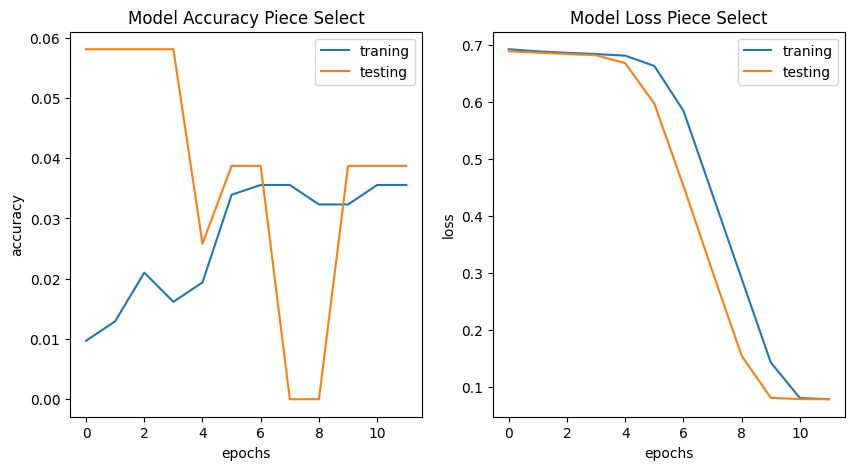

In [ ]:
if TRAINGING_MODELS:

    # Create a pandas DataFrame from the training output history
    result = pd.DataFrame(output.history)

    # Create a figure to display accuracy and loss plots
    plt.figure(figsize = (10,5))


    # Determine the piece label based on BOOLEAN_PIECE values
    piece_label = next((key for key, value in BOOLEAN_PIECE.items() if value), '4')

    # Check if it's the first model data
    first_model = not any(BOOLEAN_PIECE.values())

    # Define label for the plot based on the model type
    label = PIECE_TO_WORD[piece_label] if not first_model else "Piece Select"

    # Plot the accuracy graph
    plt.subplot(1,2,1)
    plt.plot(result['accuracy'], label = 'traning')
    plt.plot(result['val_accuracy'], label = 'testing')
    plt.title('Model Accuracy ' + label)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()


    # Plot the loss graph
    plt.subplot(1,2,2)
    plt.plot(result['loss'], label = 'traning')
    plt.plot(result['val_loss'], label = 'testing')
    plt.title('Model Loss ' + label)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

In [ ]:
if TRAINGING_MODELS:
    predictions = model.predict(test_data)

5/5 [==============================] - 0s 5ms/step


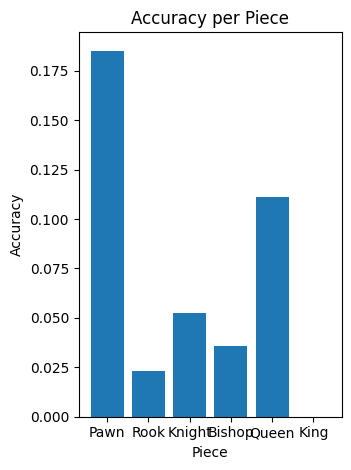

In [ ]:
# Check if the model is the first model (piece select)
first_model = not any(BOOLEAN_PIECE.values())

# Check if training models is in progress
if TRAINGING_MODELS:
    if first_model:

        # Create a subplot for plotting accuracy per piece
        plt.subplot(1, 2, 2)

        # List of piece names
        pieces = ['Pawn', 'Rook', 'Knight', 'Bishop', 'Queen', 'King']

        # Initialize arrays to store accuracy and total predictions per piece
        accuracy_per_piece = np.zeros(6)
        total_per_piece = np.zeros(6)

        # Loop through predictions and calculate accuracy per piece
        for i in range(len(predictions)):
            if i % 16000 == 0 and i > 0:
                print("Processed %d%% of total predictions" % ((i / len(predictions)) * 100))

            # Get predicted and true cell indices
            predicted_cell = np.argmax(predictions[i])
            predicted_cell = (7 - (predicted_cell // 8), predicted_cell % 8)
            predicted_cell = predicted_cell[0] * 8 + predicted_cell[1]

            true_cell = np.argmax(test_labels[i])
            true_cell = (7 - (true_cell // 8), true_cell % 8)
            true_cell = true_cell[0] * 8 + true_cell[1]

            # Get pieces at predicted and true cell positions
            board_test = convert_image_to_bitboard(test_data[i])
            predicted_piece = board_test.piece_at(predicted_cell)
            true_piece = board_test.piece_at(true_cell)

            # Calculate index of true piece for indexing accuracy arrays
            # print(predicted_piece, true_piece)
            index_true_piece = PIECE_TO_INDEX[str(true_piece).upper()]

            # Update accuracy and total counts for the piece
            accuracy_per_piece[index_true_piece] += (predicted_piece == true_piece)
            total_per_piece[index_true_piece] += 1

        # Calculate accuracy per piece as a ratio
        accuracy_per_piece /= total_per_piece

        # Plot accuracy per piece using a bar chart
        plt.bar(pieces, accuracy_per_piece)
        plt.title('Accuracy per Piece')
        plt.xlabel('Piece')
        plt.ylabel('Accuracy')

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

## Save the Model

In [ ]:
if TRAINGING_MODELS:

    # Determine the label for the saved model based on model type
    label = PIECE_TO_WORD[piece_label] if not first_model else "BASE"

    # Print the label to indicate which type of model is being saved
    print(label)

    # Define the path for saving the trained model
    PATH = MODELS_PATH + "chess_model_CNN_" + label + "4.h5"

    # Save the trained model to the specified path
    model.save(PATH)

BASE


# Retrian Model


## load the puzzles data

In [ ]:
if RETRAINING_MODELS:

    # Determine the first true piece label for retraining
    first_true_piece = next((key for key, value in BOOLEAN_PIECE.items() if value), '')
    # Define the path for the retraining dataset

    # Get retraining data and labels using the defined function
    X_train, y_train = get_puzzles_data(first_true_piece)

    # Reduce retraining data and labels to 60% of the original size
    X_train = X_train[:len(X_train) * 60 // 100]
    y_train = y_train[:len(y_train) * 60 // 100]

In [ ]:
if RETRAINING_MODELS:

    # Determine the first true piece label for retraining
    first_true_piece2 = next((key + '2' for key, value in BOOLEAN_PIECE.items() if value), '53')

    # Get retraining data and labels using the defined function
    X_train2, y_train2 = get_data(first_true_piece2)

    # Reduce retraining data and labels to 40% of the original size
    X_train2 = X_train2[:len(X_train2) * 40 // 100]
    y_train2 = y_train2[:len(y_train2) * 40 // 100]

In [ ]:
if RETRAINING_MODELS:

    # Concatenate retraining data and labels with the existing data and labels
    X_train = np.vstack((X_train, X_train2))
    y_train = np.concatenate((y_train, y_train2))

    # Clear additional retraining data arrays to free up memory
    X_train2 = []
    y_train2 = []

    # Split combined training data and labels into train and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(
        X_train, y_train, test_size=0.2, random_state=31
    )

## load the model

In [ ]:
if RETRAINING_MODELS:

    # Create a MirroredStrategy for distributed training
    strategy = tf.distribute.MirroredStrategy()

    # Scope the operations within the strategy's context
    with strategy.scope():

        # Determine the model name based on the piece label
        model_neme = PIECE_TO_WORD[first_true_piece] if not first_true_piece == '' else 'BASE'

        # Load the pre-trained model for retraining
        model = load_my_model(model_neme + '4')

        # Load a duplicate of the pre-trained model
        model2 = load_my_model(model_neme + '4')

        # Freeze the first three layers of the model (transfer learning)
        for layer in model.layers[:3]:
            layer.trainable = False

        # Remove the last layer from the model
        model.pop()

        # Define scale and standard deviation for kernel initialization
        scale = 10**(-7)
        stddev = scale / 2.0

        # Add a new Dense (fully connected) layer to the model
        model.add(Dense(64, activation='softmax',
                            kernel_initializer=RandomNormal(mean=0.0, stddev=stddev)))

        # Display the layers of the loaded model
        display(model.layers)

## define parameters

In [ ]:
batch_size = 500
num_epochs = 5
learning_rate = 0.0015

In [ ]:
# Define an EarlyStopping callback for the training process
callback_stop = EarlyStopping(monitor='accuracy',patience=5)

# Create a list of callbacks containing the EarlyStopping callback
callbacks = [callback_stop]

In [ ]:
# Scope the operations within the strategy's context
with strategy.scope():
    optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    optimizer2 = keras.optimizers.Adam(learning_rate=learning_rate)
    criterion = tf.keras.losses.BinaryCrossentropy()
    criterion2 = tf.keras.losses.BinaryCrossentropy()

In [ ]:
if RETRAINING_MODELS:
    # Compile the first retraining model with specified optimizer, loss, and metrics
    model.compile(optimizer = optimizer, loss = criterion, metrics = ['accuracy'])

    # Compile the second retraining model (duplicate) with the second optimizer, loss, and metrics
    model2.compile(optimizer = optimizer2, loss = criterion2, metrics = ['accuracy'])

In [ ]:
if RETRAINING_MODELS:
    # Transpose the training data to match the required shape (N, H, W, C)
    train_data = np.transpose(train_data, (0, 2, 3, 1))

    # Transpose the testing data similarly
    test_data = np.transpose(test_data, (0, 2, 3, 1))

    # Convert training labels to one-hot encoding with depth of 64
    train_labels = tf.one_hot(train_labels, depth=64)

    # Convert testing labels to one-hot encoding with the same depth
    test_labels = tf.one_hot(test_labels, depth=64)

In [ ]:
if RETRAINING_MODELS:

    # Print the shapes of the training and testing data and labels
    print("X_train shape: ", train_data.shape)
    print("y_train shape: ", train_labels.shape)
    print("X_test shape: ", test_data.shape)
    print("y_test shape: ", test_labels.shape)

X_train shape:  (238068, 8, 8, 6)
y_train shape:  (238068, 64)
X_test shape:  (59517, 8, 8, 6)
y_test shape:  (59517, 64)


In [ ]:
# Check if retraining models is in progress
if RETRAINING_MODELS:

    # Check if GPU is available, otherwise use CPU
    if tf.test.is_gpu_available():
        device = '/gpu:0'
    else:
        device = '/cpu:0'

    # Use TensorFlow's device context manager to manage device placement
    with tf.device(device):
        train_data = tf.convert_to_tensor(train_data)
        train_labels = tf.convert_to_tensor(train_labels)

## Run the fit (train) method



In [ ]:
if RETRAINING_MODELS:

    # Train the first retraining model
    output = model.fit(train_data, train_labels,
                      epochs = num_epochs,
                      batch_size = batch_size,
                      validation_data = (test_data, test_labels),
                      callbacks = callbacks)


    # Train the second retraining model (duplicate)
    output2 = model2.fit(train_data, train_labels,
                      epochs = num_epochs,
                      batch_size = batch_size,
                      validation_data = (test_data, test_labels),
                      callbacks = callbacks)

Epoch 1/5
477/477 [==============================] - 11s 21ms/step - loss: 0.0841 - accuracy: 0.0250 - val_loss: 0.0800 - val_accuracy: 0.0272
Epoch 2/5
477/477 [==============================] - 8s 18ms/step - loss: 0.0800 - accuracy: 0.0242 - val_loss: 0.0804 - val_accuracy: 0.0269
Epoch 3/5
477/477 [==============================] - 10s 20ms/step - loss: 0.0802 - accuracy: 0.0237 - val_loss: 0.0805 - val_accuracy: 0.0243
Epoch 4/5
477/477 [==============================] - 7s 15ms/step - loss: 0.0804 - accuracy: 0.0240 - val_loss: 0.0808 - val_accuracy: 0.0238
Epoch 5/5
477/477 [==============================] - 9s 18ms/step - loss: 0.0805 - accuracy: 0.0228 - val_loss: 0.0808 - val_accuracy: 0.0238
Epoch 1/5
477/477 [==============================] - 18s 33ms/step - loss: 0.0799 - accuracy: 0.0243 - val_loss: 0.0798 - val_accuracy: 0.0253
Epoch 2/5
477/477 [==============================] - 15s 32ms/step - loss: 0.0797 - accuracy: 0.0256 - val_loss: 0.0796 - val_accuracy: 0.0272
Ep

## visualize


In [ ]:
if RETRAINING_MODELS:

    # Evaluate the performance of the first retraining model on the test data
    model.evaluate(test_data, test_labels)

    # Evaluate the performance of the second retraining model (duplicate) on the test data
    model2.evaluate(test_data, test_labels)

3116/3116 [==============================] - 15s 5ms/step - loss: 0.0389 - accuracy: 0.4616


In [ ]:
if RETRAINING_MODELS:
    # Clear the data and labels arrays to save memory
    train_data = []
    train_labels = []
    y_train = []
    X_train = []

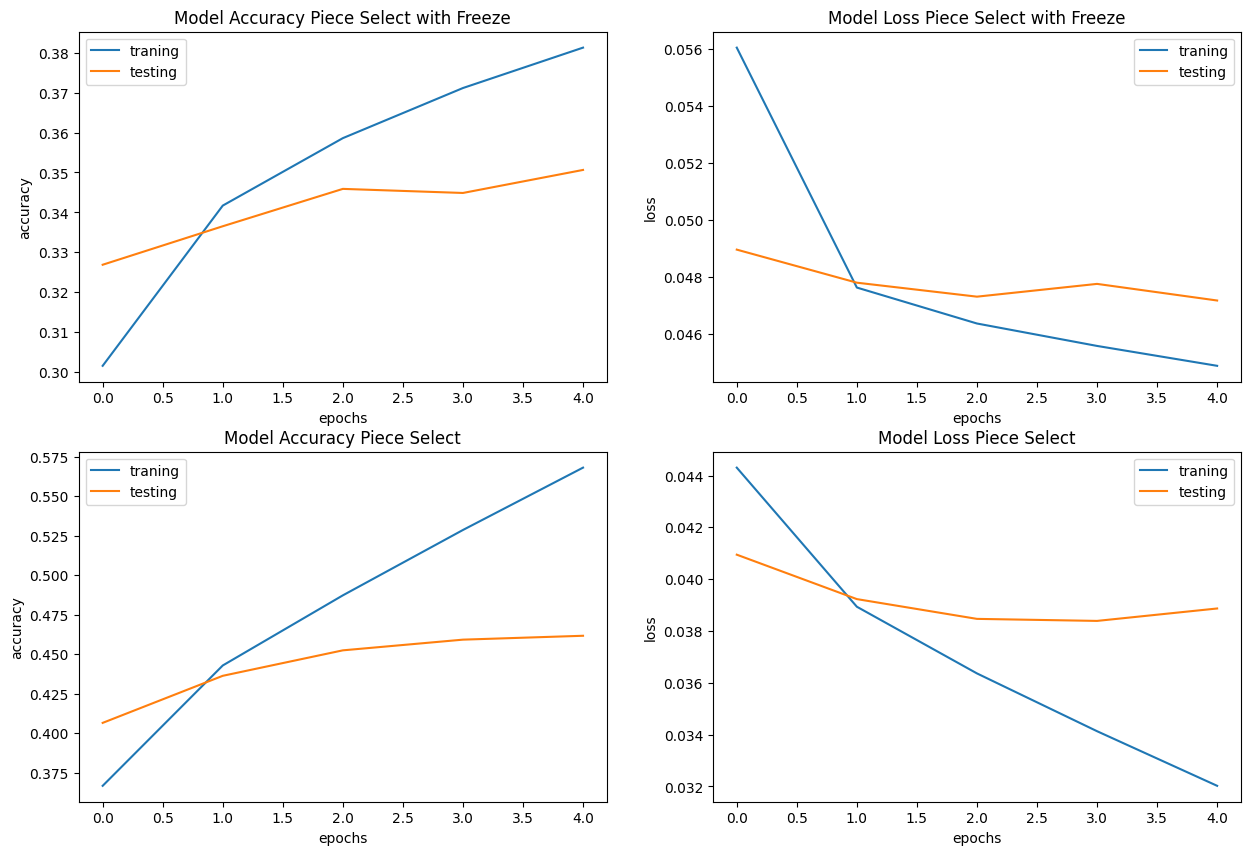

In [ ]:
if RETRAINING_MODELS:
    result = pd.DataFrame(output.history)
    plt.figure(figsize = (15,10))

    piece_label = next((key for key, value in BOOLEAN_PIECE.items() if value), '4')
    first_model = not any(BOOLEAN_PIECE.values())
    label = PIECE_TO_WORD[piece_label] if not first_model else "Piece Select"


    # Create the first subplot for accuracy of the first retraining model
    plt.subplot(2,2,1)
    plt.plot(result['accuracy'], label = 'traning')
    plt.plot(result['val_accuracy'], label = 'testing')
    plt.title('Model Accuracy ' + label + ' with Freeze')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()


    # Create the second subplot for loss of the first retraining model
    plt.subplot(2,2,2)
    plt.plot(result['loss'], label = 'traning')
    plt.plot(result['val_loss'], label = 'testing')
    plt.title('Model Loss ' + label + ' with Freeze')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    result2 = pd.DataFrame(output2.history)
    piece_label = next((key for key, value in BOOLEAN_PIECE.items() if value), '4')
    first_model = not any(BOOLEAN_PIECE.values())
    label = PIECE_TO_WORD[piece_label] if not first_model else "Piece Select"


    # Create the third subplot for accuracy of the second retraining model
    plt.subplot(2,2,3)
    plt.plot(result2['accuracy'], label = 'traning')
    plt.plot(result2['val_accuracy'], label = 'testing')
    plt.title('Model Accuracy ' + label)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()



    # Create the fourth subplot for loss of the second retraining model
    plt.subplot(2,2,4)
    plt.plot(result2['loss'], label = 'traning')
    plt.plot(result2['val_loss'], label = 'testing')
    plt.title('Model Loss ' + label)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

In [ ]:
if RETRAINING_MODELS:
    predictions = model.predict(test_data)
    predictions2 = model2.predict(test_data)

3116/3116 [==============================] - 10s 3ms/step


In [ ]:
if RETRAINING_MODELS:
    if first_model:

        # List of chess piece names
        pieces = ['Pawn', 'Rook', 'Knight', 'Bishop', 'Queen', 'King']


        # Arrays to store accuracy per piece for both models and total occurrences per piece
        accuracy_per_piece = np.zeros(6)
        accuracy_per_piece2 = np.zeros(6)
        total_per_piece = np.zeros(6)



        # Loop through predictions and calculate accuracy per piece
        for i in range(len(predictions)):
            if i % 16000 == 0 and i > 0:
                print("Processed %d%% of total predictions" % ((i / len(predictions)) * 100))


            # Convert predicted cell index to (row, col) coordinates
            predicted_cell = np.argmax(predictions[i])
            predicted_cell = (7 - (predicted_cell // 8), predicted_cell % 8)
            predicted_cell = predicted_cell[0] * 8 + predicted_cell[1]

            # Duplicate of the same conversion for second model (in case of typo)
            predicted_cell2 = np.argmax(predictions[i])
            predicted_cell2 = (7 - (predicted_cell2 // 8), predicted_cell2 % 8)
            predicted_cell2 = predicted_cell2[0] * 8 + predicted_cell2[1]


            # Convert true cell index to (row, col) coordinates
            true_cell = np.argmax(test_labels[i])
            true_cell = (7 - (true_cell // 8), true_cell % 8)
            true_cell = true_cell[0] * 8 + true_cell[1]



            # Create a bitboard from the test data image
            board_test = convert_image_to_bitboard(test_data[i])



            # Get predicted and true pieces at the specified cell
            predicted_piece = board_test.piece_at(predicted_cell)
            predicted_piece2 = board_test.piece_at(predicted_cell2)
            true_piece = board_test.piece_at(true_cell)

            # Get the index of the true piece for indexing accuracy arrays
            # print(predicted_piece, true_piece)
            index_true_piece = PIECE_TO_INDEX[str(true_piece).upper()]


            # Update accuracy_per_piece arrays based on predicted and true pieces
            accuracy_per_piece[index_true_piece] += (predicted_piece == true_piece)
            accuracy_per_piece2[index_true_piece] += (predicted_piece2 == true_piece)
            total_per_piece[index_true_piece] += 1


        # Calculate accuracy per piece by dividing by total occurrences
        accuracy_per_piece /= total_per_piece
        accuracy_per_piece2 /= total_per_piece

Processed 16% of total predictions
Processed 32% of total predictions
Processed 48% of total predictions
Processed 64% of total predictions
Processed 80% of total predictions
Processed 96% of total predictions


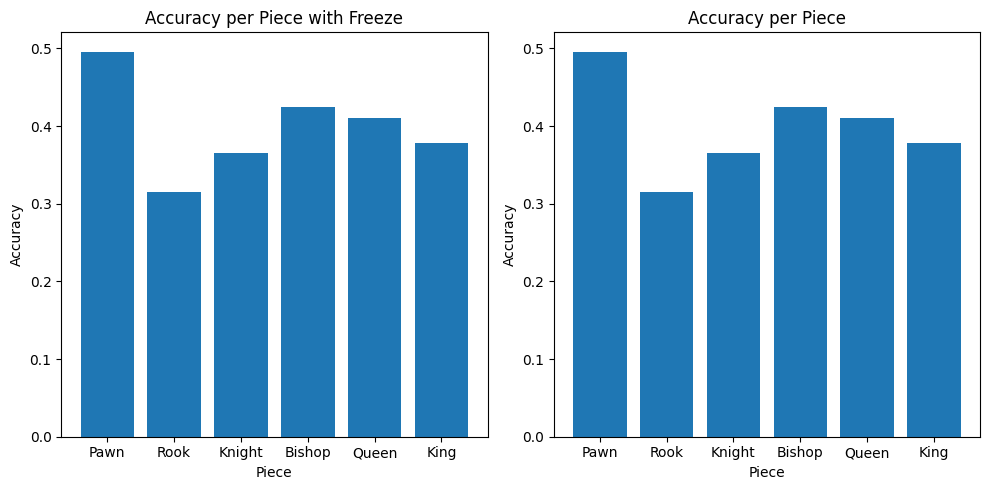

In [ ]:
# Check if retraining models is in progress
if RETRAINING_MODELS:
    if first_model:

        # Create a figure for plotting with a specified size
        plt.figure(figsize = (10,5))


        # Create the first subplot for accuracy per piece with freeze
        plt.subplot(1, 2, 1)
        plt.bar(pieces, accuracy_per_piece)
        plt.title('Accuracy per Piece with Freeze')
        plt.xlabel('Piece')
        plt.ylabel('Accuracy')
        plt.tight_layout()


        # Create the second subplot for accuracy per piece without freeze
        plt.subplot(1, 2, 2)
        plt.bar(pieces, accuracy_per_piece2)
        plt.title('Accuracy per Piece')
        plt.xlabel('Piece')
        plt.ylabel('Accuracy')
        plt.tight_layout()

        plt.show()

## save the new model

In [ ]:
if RETRAINING_MODELS:

    # Determine the label based on the piece label and whether it's the first model being retrained
    label = PIECE_TO_WORD[piece_label] if not first_model else "BASE"
    print(label)

    # Define the paths for saving the trained models with and without freeze
    PATH = MODELS_PATH + "chess_model_CNN_after_puzzles_freeze_" + label + "4.h5"
    PATH2 = MODELS_PATH + "/chess_model_CNN_after_puzzles_" + label + "4.h5"

    # Save the first retraining model with freeze
    model.save(PATH)

    # Save the second retraining model without freeze
    model2.save(PATH2)

BASE


# Test 1 to Calculate the Accuracy of the Models on the Old and the New Datasets

In [ ]:
# Determine the first true piece label based on the piece dictionary and values
first_true_piece = next((key + '2' for key, value in BOOLEAN_PIECE.items() if value), '53')

# Retrieve the X and y data using the get_data function
X_train, y_train = get_data(first_true_piece)

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    X_train, y_train, test_size=0.2, random_state=31
)

print(first_true_piece)

53


In [ ]:
# Determine the first true piece label based on the piece dictionary and values
first_true_piece = next((key for key, value in BOOLEAN_PIECE.items() if value), '')

X_train_P, y_train_P = get_puzzles_data(first_true_piece)
train_data_P, test_data_P, train_labels_P, test_labels_P = train_test_split(
    X_train_P, y_train_P, test_size=0.2, random_state=31
)

In [ ]:
X_train, y_train, X_train_P, y_train_P = [], [], [], []
train_data, train_labels = [], []

In [ ]:
# Set the test data and labels to the puzzle test data and labels
test_data = test_data_P
test_labels = test_labels_P

# Clear the puzzle train and test data and labels to free up memory
train_data_P = []
train_labels_P = []
test_data_P = []
test_labels_P = []

In [ ]:
# test_data, test_labels = [], []

In [ ]:
# Transpose the test data to match the expected input shape for the model
test_data = np.transpose(test_data, (0, 2, 3, 1))

# Convert test labels to one-hot encoding with a depth of 64
test_labels = tf.one_hot(test_labels, depth=64)

# Check if a GPU is available for computation
if tf.test.is_gpu_available():
    device = '/gpu:0'
else:
    device = '/cpu:0'

# Use the specified device (GPU or CPU) for TensorFlow operations
with tf.device(device):
    test_data = tf.convert_to_tensor(test_data)
    test_labels = tf.convert_to_tensor(test_labels)

In [ ]:
# Determine the first true piece label based on the piece dictionary and values
first_true_piece = next((key for key, value in BOOLEAN_PIECE.items() if value), '')

strategy = tf.distribute.MirroredStrategy()

# Use the strategy scope to define and load the model within the distributed strategy
with strategy.scope():
    model_neme = PIECE_TO_WORD[first_true_piece] if not first_true_piece == '' else 'BASE'
    model = load_my_model('' + model_neme + '3')

In [ ]:
model.evaluate(test_data, test_labels)

3097/3097 [==============================] - 19s 6ms/step - loss: 0.1205 - accuracy: 0.2490


[0.12048040330410004, 0.24903878569602966]

# Test 2 to Draw the Chart k vs Accuracy


## loading models

In [ ]:
# Create a MirroredStrategy for distributing the model across multiple GPUs
strategy = tf.distribute.MirroredStrategy()

# Use the strategy scope to define and load models within the distributed strategy
with strategy.scope():

    # Load the base model with the specified piece label ('BASE') using the load_piece_model function
    base_model = load_my_model('after_puzzles_' + "BASE" + '2')

    # Initialize an empty dictionary to store move models for different pieces
    move_models = {}

    # Iterate through the ARRAY_PIECE to load move models for each piece
    for piece in ARRAY_PIECE:
        move_models[piece] = load_my_model('after_puzzles_' + PIECE_TO_WORD[piece] + '2')

# Create a dictionary containing the base model and move models
model = {'base_model':base_model, 'move_models':move_models}

In [ ]:
display(model['base_model'].summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 8, 8, 96)          5280      
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 256)         221440    
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 384)         885120    
                                                                 
 flatten_4 (Flatten)         (None, 24576)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1572928   
                                                                 
Total params: 2,684,768
Trainable params: 2,684,768
Non-trainable params: 0
_________________________________________________________________


None

In [ ]:
# Load the base model and move models using the specified piece labels
base_model2 = load_my_model('after_puzzles_' + "BASE" + '2')
move_models2 = {}


# Iterate through the ARRAY_PIECE to load move models for each piece
for piece in ARRAY_PIECE:
    move_models2[piece] = load_my_model('after_puzzles_' + PIECE_TO_WORD[piece] + '2')


# Create a dictionary containing the base model and move models
model_cpu = {'base_model':base_model2, 'move_models':move_models2}

## test before moving on

In [ ]:
board = chess.Board()
board.push_san('e4')
# print(predict_from_k_move(board, 10))
# print(predict_k_move(board, 10))

fen = 'rnbqk2r/pp1p1ppp/4pn2/2P5/1bP5/2N5/PPQ1PPPP/R1B1KBNR b KQkq - 0 5'
fen = '8/7P/1B1k2K1/1p1p4/5P2/1r6/8/8 w - - 1 44'
board.set_fen(fen)
# board.push(chess.Move.from_uci('e8h8'))
# display(board)
# board.pop()
# board.push(chess.Move.from_uci('e8g8'))
# display(board)
# board.pop()
print(predict_multi_k_move([fen], 10))

[['b6c5', 'b6e3', 'b6c7', 'g6f7', 'h7h8q', 'b6a5', 'b6d4', 'b6g1', 'g6h5', 'g6g7']]


## preparing data

In [ ]:
# Function to load a specified number of PGN games from a file
# Parameters:
# - file_name: The path to the PGN file
# - num_games: The number of games to load from the file
# special load_pgn_games function

def load_special_pgn_games(file_name, num_games):
    games = []
    pgn_file = open(file_name)


    # Loop through each game index up to the specified number of games
    for index in range(num_games):
        game = chess.pgn.read_game(pgn_file)
        if game is None:
            break
        games.append(game)

    pgn_file.close() # Close the PGN file
    return games

In [ ]:
NUM_GAMES = 10

In [ ]:
# Load a specified number of games from the PGN file
games = load_special_pgn_games(PGN_FILE, NUM_GAMES)


# Print status messages
print("Finished loading the PGN file.")
print("Total number of games: %d" % len(games))

Finished loading the PGN file.
Total number of games: 10


In [ ]:
# Initialize data containers to store training data

X, y_piece = {'o':[], 'm': [],'e':[]}, {'o':[], 'm': [],'e':[]}
y_from , y_to = {'o':[], 'm': [],'e':[]}, {'o':[], 'm': [],'e':[]}

cont = 0


# Loop through the games to process the moves and collect training data
for index, game in enumerate(games):
    if index % 500 == 0:
        print("Processed %d games out of %d" % (index, NUM_GAMES))


    # Create an initial chess board
    board = chess.Board()
    moves = game.mainline_moves()

    for move_index, move in enumerate(moves):
        if str(move)[0].isalpha():
            phase = check_phase(board, move_index)

            fen = board.fen()
            if move_index % 2 == 1:
              fen = board.mirror().fen()

            from_to_chess_coords = board.parse_san(str(move))
            from_to_chess_coords = str(from_to_chess_coords)

            from_chess_coords = from_to_chess_coords[:2]
            to_chess_coords = from_to_chess_coords[2:4]

            piece = board.piece_at(chess.parse_square(from_chess_coords))



            # Handle mirrored positions for Black's moves
            if move_index % 2 == 1:
                from_chess_coords = chess.square_name(chess.square_mirror(chess.parse_square(from_chess_coords)))
                to_chess_coords = chess.square_name(chess.square_mirror(chess.parse_square(to_chess_coords)))

            board.push_san(str(move))


            # Append data to corresponding data containers
            y_piece[phase].append(str(piece))
            X[phase].append(fen)
            y_to[phase].append(from_chess_coords)
            y_from[phase].append(to_chess_coords)

# Print summary information
print("Processed %d games out of %d" % (NUM_GAMES, NUM_GAMES))
print("Total number of samples in opening : %d" % len(X['o']))
print("Total number of samples in middlegame: %d" % len(X['m']))
print("Total number of samples in endgame: %d" % len(X['e']))

Processed 0 games out of 10
Processed 10 games out of 10
Total number of samples in opening : 210
Total number of samples in middlegame: 365
Total number of samples in endgame: 119


In [ ]:
# Concatenate data from different phases into combined arrays
X = np.concatenate((X['o'], X['m'], X['e']))
y_piece = np.concatenate((y_piece['o'], y_piece['m'], y_piece['e']))
y_from = np.concatenate((y_from['o'], y_from['m'], y_from['e']))
y_to = np.concatenate((y_to['o'], y_to['m'], y_to['e']))


# Convert concatenated data into NumPy arrays
X, y_piece = np.array(X), np.array(y_piece)
y_from, y_to = np.array(y_from), np.array(y_to)

In [ ]:
# Save the generated board data to a pickle file
save_data(X, 'X_test2')
print("Finished generating board data")

# Save the generated piece labels data to a pickle file
save_data(y_piece, 'y_piece_test2')
print("Finished generating piece labels data")

# Save the generated 'from' move data to a pickle file
save_data(y_from, 'y_from_test2')
print("Finished generating from data")

# Save the generated 'to' move data to a pickle file
save_data(y_to, 'y_to_test2')
print("Finished generating to data")

Finished generating board data
Finished generating piece labels data
Finished generating from data
Finished generating to data


## loading data

In [ ]:
def get_special_test_data():
    with open(DATASET_PATH + 'X_test2.pkl', 'rb') as f:
        X = pickle.load(f)

    with open(DATASET_PATH + 'y_piece_test2.pkl', 'rb') as f:
        y_piece = pickle.load(f)

    with open(DATASET_PATH + 'y_from_test2.pkl', 'rb') as f:
        y_to = pickle.load(f)

    with open(DATASET_PATH + 'y_to_test2.pkl', 'rb') as f:
        y_from = pickle.load(f)

    return X, y_piece, y_from, y_to

X, y_piece, y_from, y_to = get_special_test_data()

In [ ]:
seed_value = 42
np.random.seed(seed_value)

num_samples = len(X)
shuffled_indices = np.random.permutation(num_samples)

In [ ]:
X = X[shuffled_indices]
y_piece = y_piece[shuffled_indices]
y_from = y_from[shuffled_indices]
y_to = y_to[shuffled_indices]

In [ ]:
X = X[:1000]
y_piece = y_piece[:1000]
y_from = y_from[:1000]
y_to = y_to[:1000]

## Calculate the Accuracy vs K

In [ ]:
k_values = list(range(1, 11))
accuracies = []

for k in k_values:
    acc = calculate_accuracy(k)
    accuracies.append(acc)
    print(f"Accuracy for k = {k}: {acc}")

Accuracy for k = 1: 0.4452449567723343
Accuracy for k = 2: 0.6412103746397695
Accuracy for k = 3: 0.7420749279538905
Accuracy for k = 4: 0.8198847262247838
Accuracy for k = 5: 0.8789625360230547
Accuracy for k = 6: 0.920749279538905
Accuracy for k = 7: 0.9438040345821326
Accuracy for k = 8: 0.9668587896253602
Accuracy for k = 9: 0.9827089337175793
Accuracy for k = 10: 0.9899135446685879


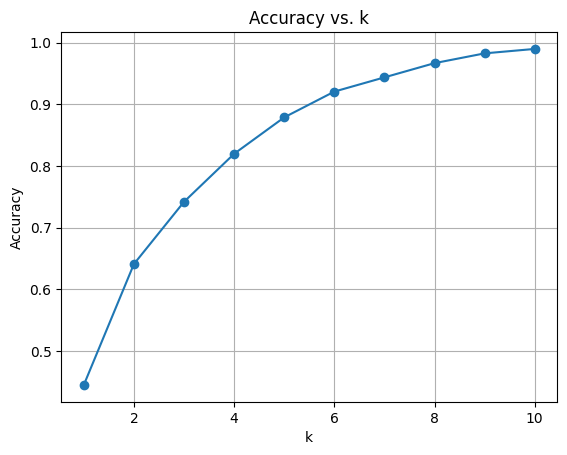

In [ ]:
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.grid(True)
plt.show()

In [ ]:
k_values = list(range(1, 11))
accuracies = []

for k in k_values:
    acc = calculate_accuracy_full_move(k)
    accuracies.append(acc)
    print(f"Accuracy for k = {k}: {acc}")

Accuracy for k = 1: 0.3112391930835735
Accuracy for k = 2: 0.43948126801152737
Accuracy for k = 3: 0.5115273775216138
Accuracy for k = 4: 0.5634005763688761
Accuracy for k = 5: 0.6167146974063401
Accuracy for k = 6: 0.6613832853025937
Accuracy for k = 7: 0.6902017291066282
Accuracy for k = 8: 0.7219020172910663
Accuracy for k = 9: 0.7449567723342939
Accuracy for k = 10: 0.7694524495677233


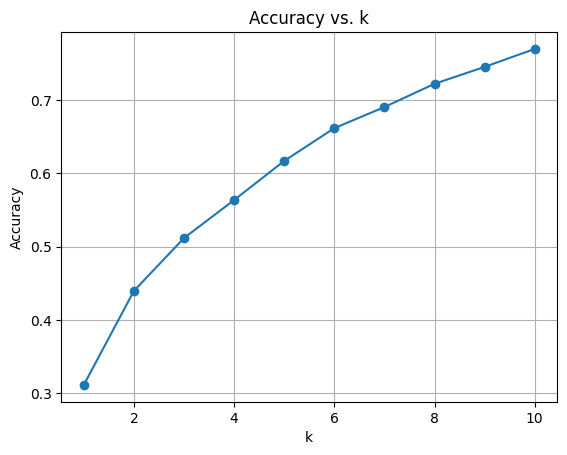

In [ ]:
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.grid(True)
plt.show()

# Test 3 The Model vs Strong Stockfish

In [ ]:
base_model = load_my_model("after_puzzles_" + "BASE" + "2")
move_models = {}
for piece in ARRAY_PIECE:
    move_models[piece] = load_my_model('after_puzzles_' + PIECE_TO_WORD[piece] + '2')

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)

In [ ]:
board = chess.Board()
game_length = 100
counter = 1
moves = []
model_cpu = {'base_model':base_model, 'move_models':move_models}

html = display_board(board, True)
save_svg(html, TEMP_PATH + "image-move-" + str(0) + ".svg")
clear_output(wait = True)
display(HTML(html))

for i in range(game_length):
    if i % 2 == 0:
      move = stockfish_play(board)
      print(move, 'stockfish')
    else:
      move = decide(board, K_FROM, EVAL_TIME_LIMIT)
      move = chess.Move.from_uci(move)
      print(move, 'my model')

    moves.append(move)
    display(board)
    board.push(move)

    html = display_board(board, True)
    save_svg(html, TEMP_PATH + "image-move-" + str(i + 1) + ".svg")
    clear_output(wait = True)
    display(HTML(html))
    # sleep(0.2)
    print('cache_hit', cache_hit)
    print('cache_called', cache_called)

    if board.is_game_over():
        break

cache_hit 76
cache_called 338


In [ ]:
print(board.move_stack)

[Move.from_uci('e2e4'), Move.from_uci('e7e5'), Move.from_uci('g1f3'), Move.from_uci('b8c6'), Move.from_uci('f1b5'), Move.from_uci('a7a6'), Move.from_uci('b5a4'), Move.from_uci('g8f6'), Move.from_uci('e1g1'), Move.from_uci('f8e7'), Move.from_uci('f1e1'), Move.from_uci('b7b5'), Move.from_uci('a4b3'), Move.from_uci('d7d6'), Move.from_uci('c2c3'), Move.from_uci('c8b7'), Move.from_uci('a2a4'), Move.from_uci('c6a5'), Move.from_uci('b3c2'), Move.from_uci('c7c5'), Move.from_uci('d2d4'), Move.from_uci('f6d7'), Move.from_uci('d1e2'), Move.from_uci('c5d4'), Move.from_uci('a4b5'), Move.from_uci('a6b5'), Move.from_uci('c3d4'), Move.from_uci('e5d4'), Move.from_uci('e2b5'), Move.from_uci('b7c6'), Move.from_uci('b5h5'), Move.from_uci('g7g6'), Move.from_uci('h5h6'), Move.from_uci('d4d3'), Move.from_uci('c2d3'), Move.from_uci('a5b3'), Move.from_uci('a1a8'), Move.from_uci('c6a8'), Move.from_uci('c1e3'), Move.from_uci('a8c6'), Move.from_uci('d3c4'), Move.from_uci('b3d2'), Move.from_uci('b1d2'), Move.from_

In [ ]:
moves = []
for move in board.move_stack:
    moves.append(move)
print(moves)

[Move.from_uci('e2e4'), Move.from_uci('e7e5'), Move.from_uci('g1f3'), Move.from_uci('b8c6'), Move.from_uci('f1b5'), Move.from_uci('a7a6'), Move.from_uci('b5a4'), Move.from_uci('g8f6'), Move.from_uci('e1g1'), Move.from_uci('f8e7'), Move.from_uci('f1e1'), Move.from_uci('b7b5'), Move.from_uci('a4b3'), Move.from_uci('d7d6'), Move.from_uci('c2c3'), Move.from_uci('c8b7'), Move.from_uci('a2a4'), Move.from_uci('c6a5'), Move.from_uci('b3c2'), Move.from_uci('c7c5'), Move.from_uci('d2d4'), Move.from_uci('f6d7'), Move.from_uci('d1e2'), Move.from_uci('c5d4'), Move.from_uci('a4b5'), Move.from_uci('a6b5'), Move.from_uci('c3d4'), Move.from_uci('e5d4'), Move.from_uci('e2b5'), Move.from_uci('b7c6'), Move.from_uci('b5h5'), Move.from_uci('g7g6'), Move.from_uci('h5h6'), Move.from_uci('d4d3'), Move.from_uci('c2d3'), Move.from_uci('a5b3'), Move.from_uci('a1a8'), Move.from_uci('c6a8'), Move.from_uci('c1e3'), Move.from_uci('a8c6'), Move.from_uci('d3c4'), Move.from_uci('b3d2'), Move.from_uci('b1d2'), Move.from_

In [ ]:
game_length = len(moves)
now = datetime.datetime.now()
now = now.strftime("%H:%M %B %d, %Y")

In [ ]:
generate_pgn_file(moves, PGN_FILE_PATH + 'game-' + now + '.pgn')

In [ ]:
convert_all(TEMP_PATH)
PATH = TEMP_PATH
images_list = []
for image_number in range(game_length):
    file_path = os.path.join(PATH, "image-move-" + str(image_number) + ".png")
    images_list.append(imageio.imread(file_path))

In [ ]:
imageio.mimsave(GIF_FILE_PATH + 'game-' + now + '.gif', images_list, duration=0.4)

# Test 4 Testing the Time Performance of the Tree

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_model = load_my_model('after_puzzles_' + "BASE")
    move_models = {}
    for piece in ARRAY_PIECE:
        move_models[piece] = load_my_model('after_puzzles_' + PIECE_TO_WORD[piece])

model_cpu = {'base_model':base_model, 'move_models':move_models}

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci("/content/drive/MyDrive/Chess_data/models/stockfish-ubuntu-x86-64-avx2")

In [ ]:
clear_cache()

In [ ]:
board = chess.Board()
board.set_fen('NR5r/3P1rpk/2n2P1p/pnP1Qq2/P1RPbP1N/BP1B1pKP/p1pp3p/b7 w - - 0 1')

start = datetime.datetime.now()
print(find_best_move_special(board, 3, 3, 6, 0.1))
end = datetime.datetime.now()

print((end - start).total_seconds())

[(inf, 'e5f5'), (684, 'e5e4'), (-570, 'd3c2')]
-903 e5f5
inf e5e4
-1021 d3c2
e5e4
17.561779


In [ ]:
clear_cache()

In [ ]:
board = chess.Board()
board.set_fen('NR5r/3P1rpk/2n2P1p/pnP1Qq2/P1RPbP1N/BP1B1pKP/p1pp3p/b7 w - - 0 1')

start = datetime.datetime.now()
print(find_best_move_special(board, 4, 4, 6, 0.1))
end = datetime.datetime.now()

print((end - start).total_seconds())

[(inf, 'e5f5'), (882, 'd3e4'), (556, 'e5e4'), (-560, 'd3c2')]
0 e5f5
975 d3e4
inf e5e4
-697 d3c2
e5e4
52.40738


# Test 5 The Model vs Stockfish with Multiple ELO

In [ ]:
stockfish = Stockfish(path=STOCKFISH_PATH)
stockfish.set_depth(15)

In [ ]:
base_model = load_my_model("after_puzzles_" + "BASE" + "2")
move_models = {}
for piece in ARRAY_PIECE:
    move_models[piece] = load_my_model('after_puzzles_' + PIECE_TO_WORD[piece] + '2')

In [ ]:
stockfish.set_elo_rating(2000)

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)

In [ ]:
start_fen = 'r2qk2r/1bp1bppp/p1np1n2/1p2p3/4P3/1B1P1N2/PPP2PPP/RNBQR1K1 w kq - 0 9'

In [ ]:
board = chess.Board()
board.set_fen(start_fen)
game_length = 100
counter = 1
moves = []
model_cpu = {'base_model':base_model, 'move_models':move_models}

html = display_board(board, True)
save_svg(html, TEMP_PATH + "image-move-" + str(0) + ".svg")
clear_output(wait = True)
display(HTML(html))

for i in range(game_length):
    if i % 2 == 1:
      stockfish.set_fen_position(board.fen())
      move = stockfish.get_best_move(2000)
      print(move, 'stockfish')
    else:
      move = decide(board, K_FROM, EVAL_TIME_LIMIT)
      print(move, 'my model')

    move = chess.Move.from_uci(move)
    moves.append(move)
    display(board)
    board.push(move)

    html = display_board(board, True)
    save_svg(html, TEMP_PATH + "image-move-" + str(i + 1) + ".svg")
    clear_output(wait = True)
    display(HTML(html))
    sleep(0.2)
    print('cache_hit', cache_hit)
    print('cache_called', cache_called)

    if board.is_game_over():
        break

cache_hit 158
cache_called 4130


In [ ]:
print(board.move_stack)

[Move.from_uci('c2c3'), Move.from_uci('c6a5'), Move.from_uci('b3c2'), Move.from_uci('c7c5'), Move.from_uci('d3d4'), Move.from_uci('e5d4'), Move.from_uci('c3d4'), Move.from_uci('e8g8'), Move.from_uci('d4d5'), Move.from_uci('a5c4'), Move.from_uci('b2b3'), Move.from_uci('c4e5'), Move.from_uci('f3e5'), Move.from_uci('d6e5'), Move.from_uci('c1b2'), Move.from_uci('f6d7'), Move.from_uci('d5d6'), Move.from_uci('e7f6'), Move.from_uci('d1e2'), Move.from_uci('d8b6'), Move.from_uci('b1c3'), Move.from_uci('b6d6'), Move.from_uci('c3d5'), Move.from_uci('b7c6'), Move.from_uci('e1d1'), Move.from_uci('f6h4'), Move.from_uci('g2g3'), Move.from_uci('h4g5'), Move.from_uci('b2c1'), Move.from_uci('g5d8'), Move.from_uci('d5e3'), Move.from_uci('d6c7'), Move.from_uci('c1b2'), Move.from_uci('g8h8'), Move.from_uci('d1d2'), Move.from_uci('f8e8'), Move.from_uci('a1d1'), Move.from_uci('d7f8'), Move.from_uci('d2d6'), Move.from_uci('d8g5'), Move.from_uci('d6d2'), Move.from_uci('g5e3'), Move.from_uci('e2e3'), Move.from_

In [ ]:
moves = []
for move in board.move_stack:
    moves.append(move)
print(moves)

[Move.from_uci('c2c3'), Move.from_uci('c6a5'), Move.from_uci('b3c2'), Move.from_uci('c7c5'), Move.from_uci('d3d4'), Move.from_uci('e5d4'), Move.from_uci('c3d4'), Move.from_uci('e8g8'), Move.from_uci('d4d5'), Move.from_uci('a5c4'), Move.from_uci('b2b3'), Move.from_uci('c4e5'), Move.from_uci('f3e5'), Move.from_uci('d6e5'), Move.from_uci('c1b2'), Move.from_uci('f6d7'), Move.from_uci('d5d6'), Move.from_uci('e7f6'), Move.from_uci('d1e2'), Move.from_uci('d8b6'), Move.from_uci('b1c3'), Move.from_uci('b6d6'), Move.from_uci('c3d5'), Move.from_uci('b7c6'), Move.from_uci('e1d1'), Move.from_uci('f6h4'), Move.from_uci('g2g3'), Move.from_uci('h4g5'), Move.from_uci('b2c1'), Move.from_uci('g5d8'), Move.from_uci('d5e3'), Move.from_uci('d6c7'), Move.from_uci('c1b2'), Move.from_uci('g8h8'), Move.from_uci('d1d2'), Move.from_uci('f8e8'), Move.from_uci('a1d1'), Move.from_uci('d7f8'), Move.from_uci('d2d6'), Move.from_uci('d8g5'), Move.from_uci('d6d2'), Move.from_uci('g5e3'), Move.from_uci('e2e3'), Move.from_

In [ ]:
game_length = len(moves)
now = datetime.datetime.now()
now = now.strftime("%H:%M %B %d, %Y")

In [ ]:
generate_pgn_file(moves, PGN_FILE_PATH + 'game-stockfish-2000-black5' + now + '.pgn', start_fen)